In [1]:
import os
import shutil
import random
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [2]:
!wget --no-check-certificate "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" -O "/tmp/cats-and-dogs.zip"

--2023-01-26 22:47:45--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.205.73.112, 2600:1408:c400:684::317f, 2600:1408:c400:68b::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.205.73.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  68.0MB/s    in 18s     

2023-01-26 22:48:03 (44.6 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [3]:
def get_valid(file_path):
    correct_files = []
    for name in os.listdir(file_path):
        try:
            img = Image.open(file_path + "/" + name)
            correct_files.append(name)
        except UnidentifiedImageError:
            pass
    return correct_files

In [4]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()
classes = ['Cat', 'Dog']
original_cat_path = '/tmp/PetImages/Cat'
original_dog_path = '/tmp/PetImages/Dog'
original_cat = get_valid(original_cat_path)
original_dog = get_valid(original_dog_path)
random.seed(101)

random.shuffle(original_cat)
random.shuffle(original_dog)
size = min(len(original_cat), len(original_dog))
train_size = int(np.floor(0.7 * size))

valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size
base_directory = 'dataset'
os.mkdir(base_directory)
type_datasets = ['train', 'valid', 'test']
directories = {}

for type_dataset in type_datasets:
    directory = os.path.join(base_directory, type_dataset)
    os.mkdir(directory)
    for name_class in classes:
        animal = os.path.join(directory, name_class)
        os.mkdir(animal)
        directories[f'{type_dataset}_{name_class}'] = animal+'/'
index = 0

for name_cat, name_dog in zip(original_cat, original_dog):
        if index <= train_size:
            type_of_dataset = 'train'
        elif train_size < index <= (train_size + valid_size):
            type_of_dataset = 'valid'
        elif (train_size + valid_size) < index <= (train_size + valid_size + test_size):
            type_of_dataset = 'test'
        shutil.copyfile(src=(original_cat_path + '/' +name_cat), dst=(directories[f'{type_of_dataset}_Cat']+name_cat))
        shutil.copyfile(src=(original_dog_path + '/' + name_dog), dst=(directories[f'{type_of_dataset}_Dog']+name_dog))
        index += 1

print(f'Dog - train: {len(os.listdir(directories["train_Dog"]))}\tCat - train: {len(os.listdir(directories["train_Cat"]))}')
print(f'Dog - valid: {len(os.listdir(directories["valid_Dog"]))}\tCat - valid: {len(os.listdir(directories["valid_Cat"]))}')
print(f'Dog - test:  {len(os.listdir(directories["test_Dog"]))}\tCat - test:  {len(os.listdir(directories["test_Cat"]))}')

/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 283
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/PIL/TiffImagePlugin.py:767: UserWar

Dog - train: 8750	Cat - train: 8750
Dog - valid: 2499	Cat - valid: 2499
Dog - test:  1250	Cat - test:  1250


In [5]:
img_width, img_height = 150, 150
train_data_dir = 'dataset/train/'
validation_data_dir = 'dataset/valid/'
epochs = 1000
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size
patience = 5
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(img_height, img_width),
                                                        batch_size=batch_size, class_mode='binary')
train_datagen_augmentation = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=30,
                                   horizontal_flip=True)
train_generator_augmentation = train_datagen_augmentation.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, class_mode='binary')

Found 17500 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


In [6]:
models = []
os.mkdir("history")
os.mkdir("charts")

In [7]:
es = EarlyStopping(patience=patience, monitor='val_accuracy', restore_best_weights=True)

In [8]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
vgg16.trainable = True

set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

for layer in vgg16.layers:
    print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')


58889256/58889256 [==============================] - 0s 0us/step
layer_name: input_1       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [10]:
model_5 = Sequential()
model_5.add(vgg16)

model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(150,150,3)))
model_5.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))

model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Flatten())
model_5.add(Dropout(0.5))
model_5.add(Dense(256, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation='relu'))
model_5.add(Dense(units=1, activation='sigmoid'))
model_5.compile(loss='binary_crossentropy',
                       optimizer=RMSprop(lr=1e-4),
                       metrics=['accuracy'])
model_5.summary()
models.append("model_5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 16)          73744     
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 16)          2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 16)         0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 32)          4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 32)          9248      
                                                        

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [11]:
history_model_5 = model_5.fit_generator(train_generator_augmentation,
                                        steps_per_epoch=steps_per_epoch,
                                        epochs=epochs,
                                        validation_data=validation_generator,
                                        validation_steps=validation_steps,
                                        callbacks=[es])

history_model_5_df = pd.DataFrame(history_model_5.history)
history_model_5_csv_file = 'history/history_model_5.csv'
with open(history_model_5_csv_file, mode='w') as f:
    history_model_5_df.to_csv(f)

<ipython-input-11-855590707781>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_model_5 = model_5.fit_generator(train_generator_augmentation,


Epoch 1/1000
136/136 [==============================] - 89s 568ms/step - loss: 0.5473 - accuracy: 0.7385 - val_loss: 0.4508 - val_accuracy: 0.8606
Epoch 2/1000
136/136 [==============================] - 72s 529ms/step - loss: 0.4403 - accuracy: 0.8837 - val_loss: 0.3729 - val_accuracy: 0.9287
Epoch 3/1000
136/136 [==============================] - 74s 541ms/step - loss: 0.3538 - accuracy: 0.9057 - val_loss: 0.2933 - val_accuracy: 0.9075
Epoch 4/1000
136/136 [==============================] - 73s 535ms/step - loss: 0.2539 - accuracy: 0.9105 - val_loss: 0.1474 - val_accuracy: 0.9467
Epoch 5/1000
136/136 [==============================] - 72s 532ms/step - loss: 0.1952 - accuracy: 0.9251 - val_loss: 0.1392 - val_accuracy: 0.9459
Epoch 6/1000
136/136 [==============================] - 73s 536ms/step - loss: 0.1733 - accuracy: 0.9349 - val_loss: 0.2066 - val_accuracy: 0.9319
Epoch 7/1000
136/136 [==============================] - 73s 534ms/step - loss: 0.1682 - accuracy: 0.9375 - val_loss: 0

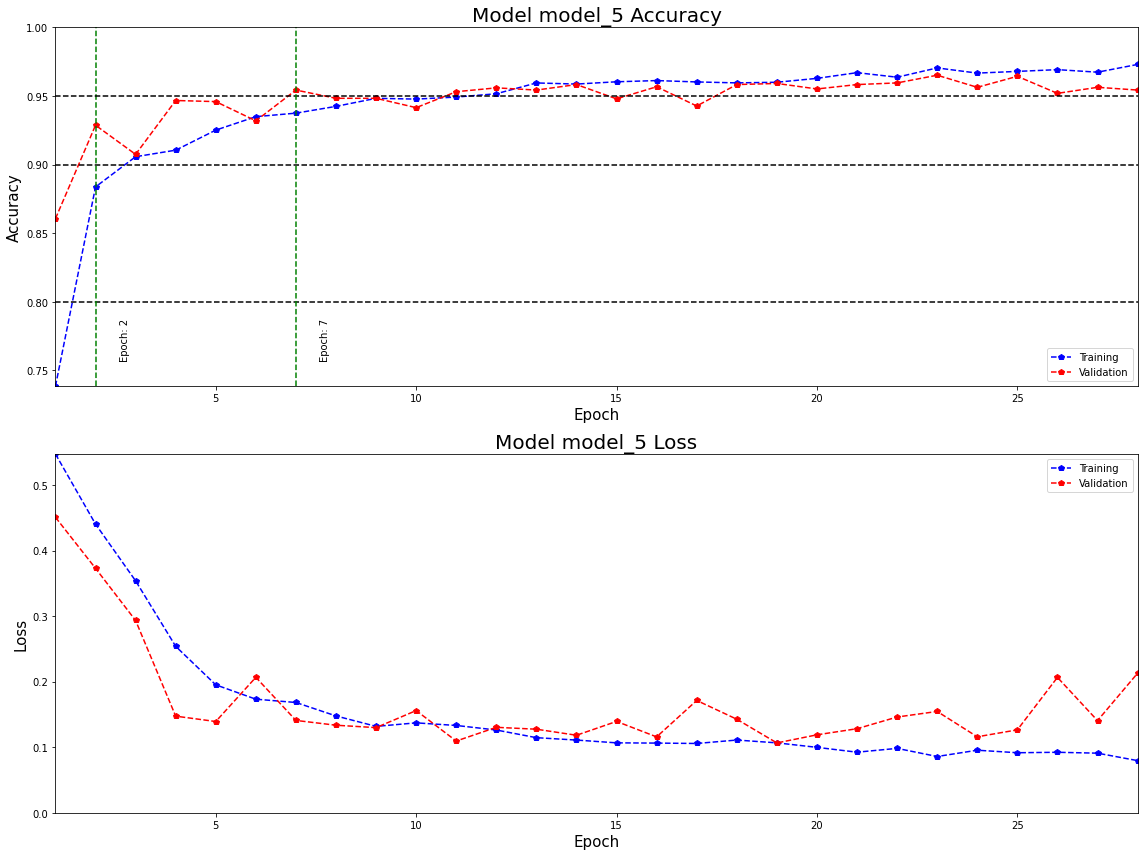

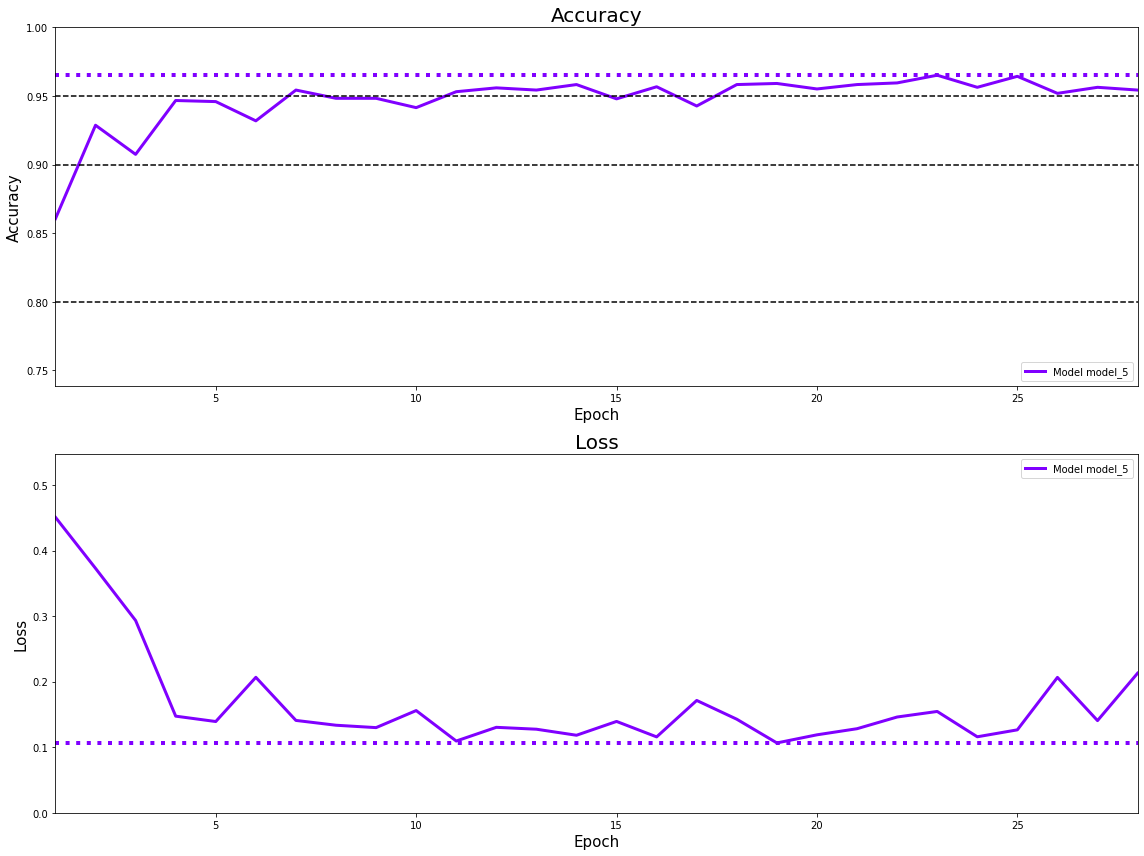

In [12]:
max_index = 0
min_accuracy = 1
max_loss = 0
colors = plt.cm.rainbow(np.linspace(0, 1, len(models)))

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    if max_index < max(df.index):
        max_index = max(df.index)
    if min_accuracy > min(df[['accuracy', 'val_accuracy']].min()):
        min_accuracy = min(df[['accuracy', 'val_accuracy']].min())
    if max_loss < max(df[['loss', 'val_loss']].max()):
        max_loss = max(df[['loss', 'val_loss']].max())

for model in models:
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(211)
    ax.plot(df['accuracy'], "bp--")
    ax.plot(df['val_accuracy'], "rp--")
    ax.set_title(f'Model {model} Accuracy', fontsize=20)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([min_accuracy, 1])

    for milestone in (0.7, 0.8, 0.9, 0.95):
        ax.axhline(milestone, color="k", linestyle="--")
        try:
            if min(df[df['val_accuracy'] >= milestone].index) > 1:
                plt.axvline(min(df[df['val_accuracy'] >= milestone].index), color="g", linestyle="--")
                ax.text(min(df[df['val_accuracy'] >= milestone].index)+0.6, min_accuracy+0.02,
                        f'Epoch: {min(df[df["val_accuracy"] >= milestone].index)}', rotation=90)
        except:
            pass

    plt.legend(['Training', 'Validation'], loc='lower right')
    ax = fig.add_subplot(212)
    ax.plot(df['loss'], "bp--")
    ax.plot(df['val_loss'], "rp--")
    ax.set_title(f'Model {model} Loss', fontsize=20)
    ax.set_ylabel('Loss', fontsize=15)
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_xlim([1, max_index])
    ax.set_ylim([0, max_loss])
    ax.legend(['Training', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig(f'charts/train_history_{model}.png', transparent=True, dpi=600)
    plt.show()

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(211)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_accuracy'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_accuracy'].max(), color=color, linestyle="dotted", linewidth=4)

ax.set_title(f'Accuracy', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([min_accuracy, 1])
for milestone in (0.7, 0.8, 0.9, 0.95):
    ax.axhline(milestone, color="k", linestyle="--")
plt.legend(loc='lower right')
ax = fig.add_subplot(212)
for model, color in zip(models, colors):
    df = pd.read_csv(f'history/history_{model}.csv', index_col=0)
    df.index += 1
    ax.plot(df['val_loss'], label=f'Model {model}', color=color, linewidth=3)
    ax.axhline(df['val_loss'].min(), color=color, linestyle="dotted", linewidth=4)
ax.set_title(f'Loss', fontsize=20)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlabel('Epoch', fontsize=15)
ax.set_xlim([1, max_index])
ax.set_ylim([0, max_loss])
ax.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'charts/train_history_of_each_model.png', transparent=True, dpi=600)
plt.show()